# Data Pre-processing and Visualization

## Data Loading

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import regex as re
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt


class Counter:
    def __init__(self, start_value: int = 42) -> None:
        self.__start_value = start_value

    def get_next(self):
        self.__start_value += 1
        return self.__start_value


file_name = "dataset_all_days_started_30_06_23"
data_path = f'/workspaces/msc_thesis/data/final_data/{file_name}.csv'
print(f'{data_path=}')

figure_base_path = f"/workspaces/msc_thesis/data/figures/modelling/{file_name}/"
if not os.path.exists(figure_base_path):
    os.makedirs(figure_base_path)
print(f'{figure_base_path=}')


def safe_save_fig(output_path):
    """Helper method to safe figures in a potentially non-existent directory."""
    dir_name = os.path.dirname(output_path)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    plt.savefig(output_path)


df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

print(f'{len(df)=}.')
print(f'{len(df.columns)=}\n')
print(f'{df.columns=}')

# The number of headers containing metadata; i.e., the stuff that's unusable for inference.
meta_header_count = 5
pr_merged_key = 'PullRequestIsMerged'
first_time_contributor_key = 'SubmitterIsFirstTimeContributor'

random_state_counter = Counter()


data_path='/workspaces/msc_thesis/data/final_data/dataset_all_days_started_30_06_23.csv'
figure_base_path='/workspaces/msc_thesis/data/figures/modelling/dataset_all_days_started_30_06_23/'


len(df)=1829971.
len(df.columns)=42

df.columns=Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'IntraProjectSubmitterPullRequestSubmissionCount',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'IntraProjectSubmitterPullRequestCommentCount',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSubmissionCount',
       'EcosystemExperienceSubmitterPullRequestCommentCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBy

## Field classification

Defines fields that should be log-transformed, removed entirely, or are a binary variable.

In [101]:
binary_fields = [
    "ControlHasHashTagInDescription",
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments"
]

print(f'{len(binary_fields)=}')

print(f'{df.columns=}')
print(f'{df.columns[df.isna().any()].tolist()=}')
# df = df.dropna()


len(binary_fields)=4
df.columns=Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'IntraProjectSubmitterPullRequestSubmissionCount',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'IntraProjectSubmitterPullRequestCommentCount',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSubmissionCount',
       'EcosystemExperienceSubmitterPullRequestCommentCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
    

## Data Visualization

### Creating pulls over time histogram

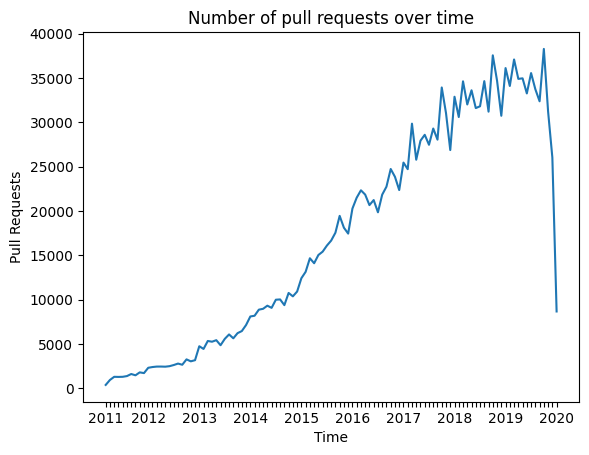

In [102]:
dates = pd.to_datetime(df['Closed At'], format="%Y-%m-%dT%H:%M:%SZ")

pr_count_per_year_month = dates.groupby(
    [dates.dt.year, dates.dt.month]).count()
axs = pr_count_per_year_month.plot(kind="line")

# Fixes x-ticks to be less cluttered.
xticks_years = []
last_year = -1
for (year, _) in pr_count_per_year_month.keys():
    if last_year != year:
        last_year = year
        xticks_years.append(year)
    else:
        xticks_years.append('')
axs.set_xticks(range(len(xticks_years)))
axs.set_xticklabels(xticks_years)

axs.set_xlabel("Time")
axs.set_ylabel("Pull Requests")
axs.set_title("Number of pull requests over time")

output_path = f'{figure_base_path}/demographics/pr_count_per_year_month.png'
safe_save_fig(output_path)

plt.show()


### Creating pulls per project histogram

percentile=98
percentile_index=19660
Top project count: 402
Pull Requests below 98th percentile: 943630/1829971 (51.565%)



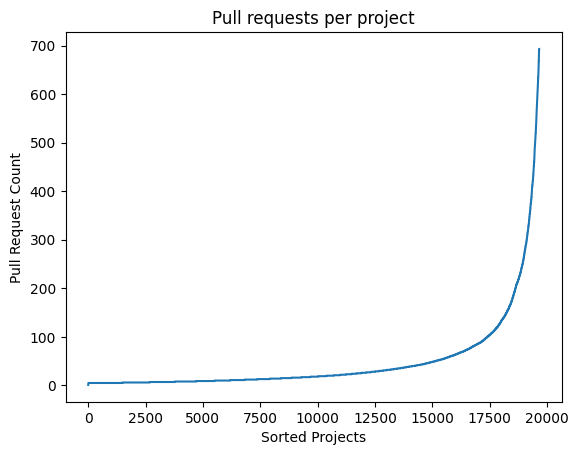

In [103]:

def __plot(__df, figure_name: str):
    plt.clf()
    axs = __df.plot(kind="line", use_index=False)
    axs.set_xlabel("Sorted Projects")
    axs.set_ylabel("Pull Request Count")
    axs.set_title("Pull requests per project")
    output_path = f'{figure_base_path}/demographics/{figure_name}.png'
    safe_save_fig(output_path)


# all data plot
pr_count_per_project = dates.groupby(df['Project Name']).count()
pr_count_per_project = pr_count_per_project.sort_values()
__plot(pr_count_per_project, "prs_per_project_all")

# up to 97th Percentile plot
project_count = len(pr_count_per_project)
# NOTE: with the 74th percentile the PR counts of the capped
# elite and the rest are approximately equal. The total number
# of entries is then 479.801.
percentile = 98
print(f'{percentile=}')
percentile_index = math.floor(project_count * percentile / 100)
print(f'{percentile_index=}')
print(f'Top project count: {project_count - percentile_index}')
perc_data = pr_count_per_project.iloc[:percentile_index]
__plot(perc_data, f"prs_per_project_up_to_{percentile}th_percentile")

# Printing some stats.
total_pull_count = sum(pr_count_per_project.values)
bottom_pull_count = sum(perc_data.values)
ratio = 100 * bottom_pull_count / total_pull_count
print(f'Pull Requests below {percentile}th percentile: '
      + f'{bottom_pull_count}/{total_pull_count} ({ratio:.03f}%)\n')

# # TODO: Figure out whether a cap should be used.
# pulls_cap = max(perc_data.values)
# capped_top_pulls_count = pulls_cap * (project_count - percentile_index)
# print(f'{pulls_cap=}')
# print(f'{capped_top_pulls_count=}')
# print(f'{bottom_pull_count + capped_top_pulls_count=}')


### Creating predictor histograms

ControlIntegratedBySameUser
ControlPullRequestLifeTimeInMinutes
ControlPullRequestHasComments
ControlNumberOfCommitsInPullRequest
ControlPullRequestHasCommentByExternalUser
ControlHasHashTagInDescription
PullRequestIsMerged
SubmitterIsFirstTimeContributor
ControlIntraProjectPullRequestExperienceOfIntegrator
IntraProjectSubmitterPullRequestSubmissionCount
IntraProjectSubmitterPullRequestSuccessRate
IntraProjectSubmitterPullRequestCommentCount
EcosystemExperienceSubmitterPullRequestSuccessRate
EcosystemExperienceSubmitterPullRequestSubmissionCount
EcosystemExperienceSubmitterPullRequestCommentCount
SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator
SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter
SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator
SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter
SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter
DependencyEcosystemExperienceSubmitterP

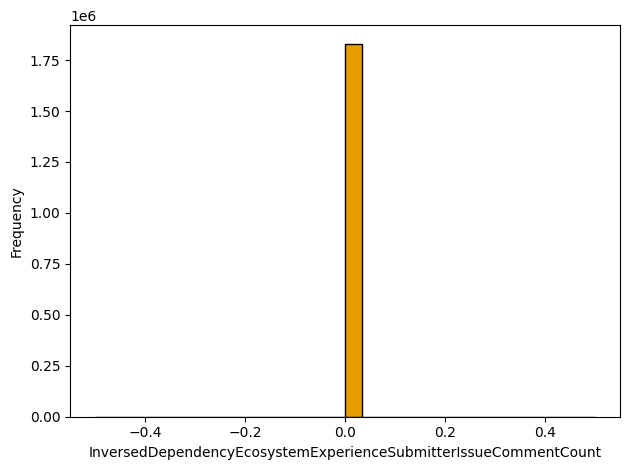

In [104]:
import copy
# shown_fields_without_zeroes = [
#     *log_transformed_fields,
#     *new_log_transformed_fields
# ]
# rx = r'.*(NumberOfCommitsInPullRequest|PullRequestLifeTimeInMinutes).*'
# shown_fields_without_zeroes = set([entry for entry in shown_fields_without_zeroes
#                                    if len(list(re.finditer(rx, entry))) == 0])
# print(f'{shown_fields_without_zeroes=}')

default_plot_settings = {
    'edgecolor': 'black',
    'color': "#e69d00"
}

default_plot_settings_2 = copy.deepcopy(default_plot_settings)
default_plot_settings_2['color'] = "#56b3e9"


def __fix_x_label_fontsize(__column):
    # Adjusts x-label's fontsize to fit the text.
    fig = plt.gcf()
    fig_width = fig.get_figwidth()
    xlabel_fontsize = int(fig_width * 100 / len(__column))
    ax = plt.gca()
    orig_fontsize = ax.xaxis.label.get_fontsize()
    ax.xaxis.label.set_fontsize(min(xlabel_fontsize, orig_fontsize))


def create_histogram(__df: pd.DataFrame, __column: str, subfolder_name: str = ""):
    can_create_feature_histograms = True

    if not can_create_feature_histograms:
        return

    print(__column)
    plt.clf()
    entries = __df[__column]

    if __column in binary_fields or __column in [pr_merged_key, first_time_contributor_key]:
        entries = __df[__column].replace({False: 0, True: 1})
        plt.xticks([0, 1], ['False', 'True'])
        plt.hist(entries, bins=2, **default_plot_settings)
        plt.ylabel('Frequency')
    # elif column in shown_fields_without_zeroes:
    #     _, bins, _ = plt.hist(entries, bins=30, alpha=1,
    #              label="All Data", **default_plot_settings)
    #     ax:plt.Axes = plt.gca()
    #     ax.set_ylabel("Frequency")
    #     ax.set_xlabel(column)
    #     __fix_x_label_fontsize()

    #     filtered_data = __df[column][__df[column] != 0]
    #     ax2 = ax.twinx()

    #     ax2.hist(filtered_data, bins, alpha=0.5,
    #              label='Excl. zeroes',**default_plot_settings_2)
    #     ax2.set_ylabel("Frequency (Excl. Zeroes)")
    #     ax2.set_zorder(10)
    #     plt.tight_layout()
    else:
        plt.hist(entries, bins=30, **default_plot_settings)
        plt.ylabel('Frequency')

    plt.xlabel(__column)
    __fix_x_label_fontsize(__column)
    plt.tight_layout()

    output_path = f"{figure_base_path}/distributions/{subfolder_name}/{__column}.png"
    safe_save_fig(output_path)


def create_predictor_histograms(__df: pd.DataFrame, subfolder_name: str = ""):
    # Iterate over the columns and generate histograms
    for column in __df.columns[meta_header_count:]:
        create_histogram(__df, column, subfolder_name)

create_predictor_histograms(df)


## Data Sieving

### Log-transformation

len(log_transformed_fields)=9
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)


ln(1 + ControlNumberOfCommitsInPullRequest)
ln(1 + ControlPullRequestLifeTimeInMinutes)
ln(1 + EcosystemExperienceSubmitterIssueCommentCount)
ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)
ln(1 + IntraProjectSubmitterPullRequestCommentCount)
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)


,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator,SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter,SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator,SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter,SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter,...,InversedDependencyEcosystemExperienceSubmitterIssueCommentCount,ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount),ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)
count,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1829971.0,1829971.0,1829971.0,...,1829971.0,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06
mean,1.477388e+08,5.221765e+06,3.826635e+03,5.792611e-01,5.057427e-01,9.593894e+00,1.851191e+00,0.0,0.0,0.0,...,0.0,5.038964e+00,1.092371e+00,6.528210e+00,3.283468e+00,2.173231e+00,2.222804e+00,2.073380e+00,2.135543e+00,2.232217e+00
std,1.004206e+08,8.133002e+06,8.058630e+03,4.452852e-01,4.126240e-01,5.506976e+01,1.607797e+01,0.0,0.0,0.0,...,0.0,2.372565e+00,6.779162e-01,3.287971e+00,2.432918e+00,1.778705e+00,2.280908e+00,2.018514e+00,2.257911e+00,2.051586e+00
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,0.000000e+00,0.000000e+00,1.652930e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.839865e+07,4.648220e+05,1.010000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,3.295837e+00,6.931472e-01,3.994524e+00,1.098612e+00,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.376254e+08,1.630457e+06,5.560000e+02,8.571429e-01,6.562500e-01,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,5.036953e+00,6.931472e-01,6.895598e+00,3.178054e+00,1.945910e+00,1.609438e+00,1.609438e+00,1.386294e+00,1.791759e+00
75%,2.280878e+08,6.388788e+06,2.873000e+03,9.758065e-01,9.000000e-01,1.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.0,6.748760e+00,1.386294e+00,8.902782e+00,5.204007e+00,3.555348e+00,3.931826e+00,3.555348e+00,3.871201e+00,3.912023e+00
max,3.617756e+08,5.976123e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.789000e+03,8.650000e+02,0.0,0.0,0.0,...,0.0,1.035752e+01,9.210440e+00,1.531725e+01,9.989849e+00,7.906179e+00,9.540363e+00,8.837971e+00,9.539356e+00,8.465479e+00


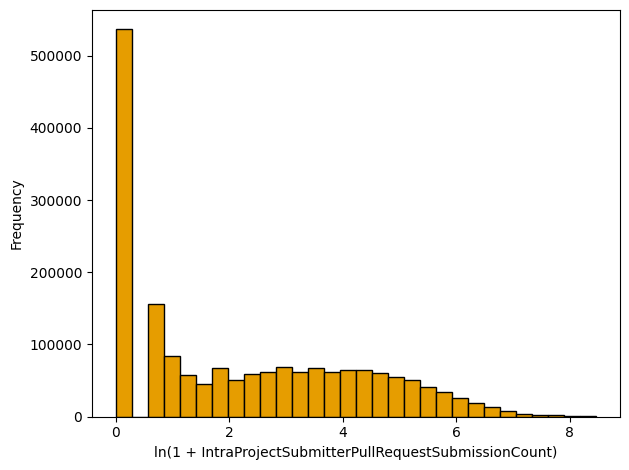

In [105]:
log_transformed_fields = [
    "ControlIntraProjectPullRequestExperienceOfIntegrator",
    "ControlNumberOfCommitsInPullRequest",
    "ControlPullRequestLifeTimeInMinutes",

    "EcosystemExperienceSubmitterIssueCommentCount",
    "EcosystemExperienceSubmitterIssueSubmissionCount",
    "EcosystemExperienceSubmitterPullRequestCommentCount",
    "EcosystemExperienceSubmitterPullRequestSubmissionCount",

    "IntraProjectSubmitterPullRequestCommentCount",
    "IntraProjectSubmitterPullRequestSubmissionCount",
]

print(f'{len(log_transformed_fields)=}')

new_log_transformed_fields = []
for field in log_transformed_fields:
    new_field_name = f'ln(1 + {field})'
    new_log_transformed_fields.append(new_field_name)
    df[new_field_name] = np.log(1 + df[field])
    create_histogram(df, new_field_name)

df = df.drop(log_transformed_fields, axis=1)

df.describe()


### Binarizes fields

bin(SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)
False    1297343
True      532628
Name: count, dtype: int64
bin(SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)
bin(SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)
False    1689578
True      140393
Name: count, dtype: int64
bin(SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)


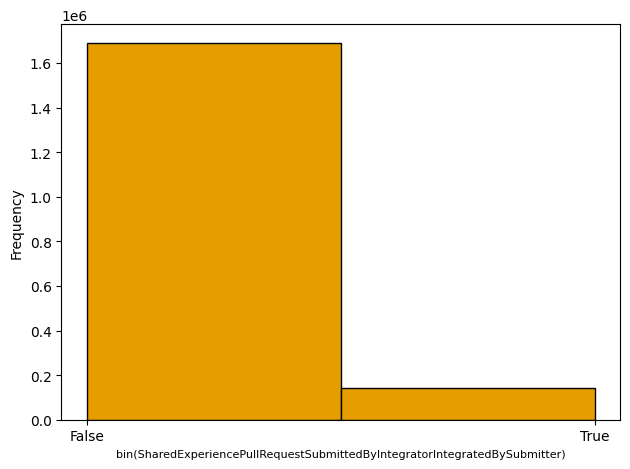

In [106]:
def to_binary(__df, column):
    new_field = f'bin({column})'
    __df.loc[:,new_field] = __df[column].apply(lambda x: x > 0)
    return __df, new_field

binarized_fields = [
    'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
    "SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter",
]

for field in binarized_fields:
    df, new_field = to_binary(df, field)
    binary_fields.append(new_field)

    print(df[new_field].value_counts())
    create_histogram(df, new_field)

df = df.drop(binarized_fields, axis=1)


Removes unusable fields.

In [107]:
removed_fields = [
    "DependencyEcosystemExperienceSubmitterIssueCommentCount",
    "DependencyEcosystemExperienceSubmitterIssueSubmissionCount",
    'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
    "DependencyEcosystemExperienceSubmitterPullRequestCommentCount",
    "DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount",

    "IntraProjectSubmitterIssueCommentCount",
    "IntraProjectSubmitterIssueSubmissionCount",

    "InversedDependencyEcosystemExperienceSubmitterIssueCommentCount",
    "InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount",
    'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
    "InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount",
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount",

    "SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter",
    'SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter',
    "SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator",

    "SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter",
    "SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter",
    "SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator",
]

print(f'{len(removed_fields)=}')

df = df.drop(removed_fields, axis=1)


len(removed_fields)=18


Downsamples the dataset in case you set ``sample`` to ``>0`` (for debugging).

In [108]:
sample_size = 0
if sample_size > 0:
    df = df.sample(sample_size)
    print("WARNING: TRAINING WITH SAMPLE!")


## Assessing logistic regression assumptions

### Multicolinearity

In [109]:
def change_bin_fields_to_float(__df):
    value_mapper = {False: 0, True: 1}
    for feature in binary_fields:
        __df.loc[:, feature] = __df[feature].replace(value_mapper)
    return __df

In [110]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# create DataFrame to hold VIF values
vif_df = pd.DataFrame()
multi_colinear_fields = [
    # "bin(SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)",

    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",

    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",

    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
]

tested_predictors = df.drop(df.columns[:meta_header_count], axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)
tested_predictors = tested_predictors.drop(multi_colinear_fields, axis=1)
tested_predictors = tested_predictors.drop(
    [pr_merged_key, first_time_contributor_key], axis=1)

vif_df['variable'] = tested_predictors.columns

print(tested_predictors.columns)
# calculate VIF for each predictor variable
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'bin(SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'bin(SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)'],
      dtype='object')
                                             variable       VIF
0                         ControlIntegratedBySameUser  4.103351
1                       ControlPullRequestHasComments  4.011393
2          ControlPullRequestHasCommentByExternalUser  1.877226
3                      ControlHasHashTagInDescription  1.709833
4         IntraProjectSubmit

In [111]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF scores:
                                            variable       VIF
4        IntraProjectSubmitterPullRequestSuccessRate  5.335508
6  ln(1 + ControlIntraProjectPullRequestExperienc...  5.129963


coof=0.5
Correlating pairs:
[
    [
        "bin(SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)",
        "ControlIntegratedBySameUser"
    ]
]

Variable correlation frequency:
[
    [
        "bin(SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)",
        1
    ],
    [
        "ControlIntegratedBySameUser",
        1
    ]
]

Transitive closure of correlating pairs:
[
    [
        "bin(SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)",
        "ControlIntegratedBySameUser"
    ],
    []
]


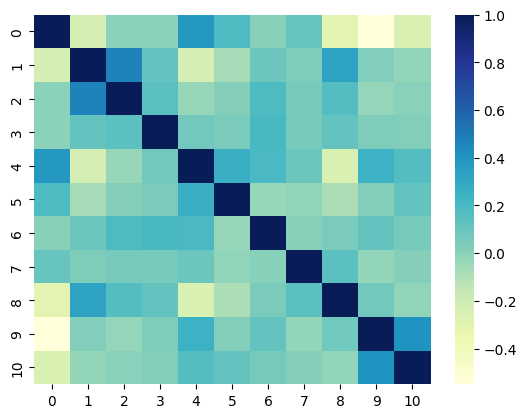

In [112]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr()
dataplot = sb.heatmap(corr, cmap="YlGnBu",
                      xticklabels=tick_labels, yticklabels=tick_labels)


def get_correlating_fields(coof, corr):
    print(f'{coof=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, value in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(value) < coof:
                continue
            correlating_fields.append([columnIndex, rowIndex])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


unified = unify_if_overlapping(correlating_fields)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


In [113]:
df = df.drop(multi_colinear_fields, axis=1)
print(df.columns)

Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'bin(SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'bin(SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)'],
      dtype='object')


### Log-odds independence

continuous_var=Index(['IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)'],
      dtype='object')


ln(.) x IntraProjectSubmitterPullRequestSuccessRate
ln(.) x EcosystemExperienceSubmitterPullRequestSuccessRate
ln(.) x ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)
ln(.) x ln(1 + ControlNumberOfCommitsInPullRequest)
ln(.) x ln(1 + ControlPullRequestLifeTimeInMinutes)
cols_to_keep=['ln(.) x IntraProjectSubmitterPullRequestSuccessRate', 'ln(.) x EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(.) x ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(.) x ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(.) x ln(1 + ControlPullRequestLifeTimeInMinutes)', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlPullRequestLifeTimeInMinutes)']
                  Generalized Linear Model Regression Results                  
Dep. Variable:     PullRequestIsMerged   No. Observations:      

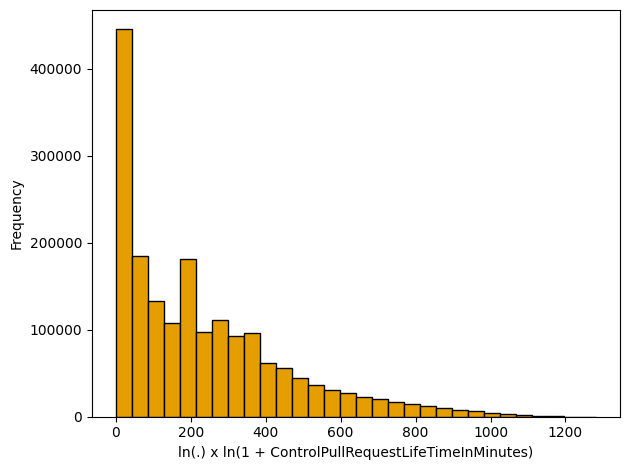

In [114]:
import statsmodels.api as sm

# Define continuous variables
y = df[pr_merged_key]
continuous_var = df.columns[meta_header_count:] \
    .drop(binary_fields) \
    .drop([pr_merged_key, first_time_contributor_key])
print(f'{continuous_var=}')

df_tmp = df.copy()

# Add logit transform interaction terms (natural log) for continuous variables e.g.. Age * Log(Age)
for var in continuous_var:
    ln_var_name = f'ln(.) x {var}'
    df_tmp[ln_var_name] = df_tmp[var].apply(lambda x: (x ** 2) * np.log(1 + (x ** 2)))

    create_histogram(df_tmp, ln_var_name, "tmp")


# Keep columns related to continuous variables
cols_to_keep = df_tmp.columns.tolist()[-len(continuous_var):]
cols_to_keep.extend(continuous_var)
print(f'{cols_to_keep=}')

# Redefining variables to include interaction terms
X_lt = df_tmp[cols_to_keep]

# Add constant term
X_lt_constant = sm.add_constant(X_lt, prepend=False)

# Building model and fit the data (using statsmodel's Logit)
logit_results = sm.GLM(y, X_lt_constant, family=sm.families.Binomial()).fit()
# logit_results = sm.Logit(y, X_lt_constant).fit()

# Display summary results
print(logit_results.summary())


## Creating train and test data.

In [115]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = max(class_counts) / min(class_counts)
majority_class = class_counts[np.argmax(class_counts)]
print(f'{class_counts=}')
print(f'{class_imbalance=}\n')


def is_majority_class(label) -> bool:
    """
    Helper method for standardizing majority 
    class filtering later in the notebook.
    """

    # NOTE: You have to manually change this
    # if the majority class is different.
    return label


def get_imbalance_weights(__df):
    return list([1.0 if is_majority_class(label) else class_imbalance
                 for label in __df])


# Makes 80:20 dataset splits for testing/training
train, test = train_test_split(df, test_size=0.2)
print(f'{len(train)=}, {len(test)=}\n')

# Labels
train_labels = train[pr_merged_key]
test_labels = test[pr_merged_key]
all_labels = df[pr_merged_key]

# Imbalance weights
train_imbalance_weights = get_imbalance_weights(train_labels)
test_imbalance_weights = get_imbalance_weights(test_labels)

# Predictors
used_predictor_labels = df.columns[meta_header_count:].drop(
    [pr_merged_key, first_time_contributor_key])
train_predictors = train[used_predictor_labels]
test_predictors = test[used_predictor_labels]
all_predictors = df[used_predictor_labels]
print(f'{len(used_predictor_labels)=}')
print(f'{used_predictor_labels=}')

print(all_predictors)

all_predictors.describe()


class_counts=PullRequestIsMerged
True     1407650
False     422321
Name: count, dtype: int64
class_imbalance=3.3331281181849826

len(train)=1463976, len(test)=365995

len(used_predictor_labels)=11
used_predictor_labels=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'bin(SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'bin(SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)'],
      dtype='object')
         ControlIntegratedBySameUser  ControlPullRequestHasComments   
0                              False                      

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlPullRequestLifeTimeInMinutes)
count,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06,1.829971e+06
mean,5.792611e-01,5.057427e-01,5.038964e+00,1.092371e+00,6.528210e+00
std,4.452852e-01,4.126240e-01,2.372565e+00,6.779162e-01,3.287971e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.652930e-02
25%,0.000000e+00,0.000000e+00,3.295837e+00,6.931472e-01,3.994524e+00
50%,8.571429e-01,6.562500e-01,5.036953e+00,6.931472e-01,6.895598e+00
75%,9.758065e-01,9.000000e-01,6.748760e+00,1.386294e+00,8.902782e+00
max,1.000000e+00,1.000000e+00,1.035752e+01,9.210440e+00,1.531725e+01


# Modelling (Full Model)

## Random Forest

### Model Creation (Weighted)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report


def create_weighted_rf_model(__test_labels, __test_predictors, __test_weights,
                             __train_labels, __train_predictors, __train_weights):
    # Model creation and predictions.
    random_state = random_state_counter.get_next()
    print(f'{random_state=}')
    weighted_rf = RandomForestRegressor(
        n_estimators=100, random_state=random_state)
    weighted_rf.fit(__train_predictors, __train_labels,
                    sample_weight=__train_weights)

    predictions = weighted_rf.predict(__test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # Absolute error
    absolute_error = abs(predictions ^ __test_labels)
    print(f'Absolute error: {absolute_error}')

    # F1 scores.
    conf = confusion_matrix(__test_labels, predictions,
                            sample_weight=__test_weights)
    weighted_f1 = f1_score(__test_labels, predictions,
                           sample_weight=__test_weights)
    print(f'{weighted_f1=}')
    unweighted_f1 = f1_score(__test_labels, predictions)
    print(f'{unweighted_f1=}')

    # Other metrics.
    print(f'{conf=}')
    print(classification_report(
        __test_labels, predictions,
        sample_weight=__test_weights
    ))

    return weighted_rf


weighted_rf = create_weighted_rf_model(test_labels, test_predictors, test_imbalance_weights,
                                       train_labels, train_predictors, train_imbalance_weights)


random_state=43
Absolute error: 1551773    False
677644     False
1777792    False
1271863    False
1561008     True
           ...  
946764     False
910805     False
1553043    False
788510      True
929871     False
Name: PullRequestIsMerged, Length: 365995, dtype: bool
weighted_f1=0.8029204430463169
unweighted_f1=0.913239714842735
conf=array([[167349.69655793, 114072.97671679],
       [ 16197.        , 265366.        ]])
              precision    recall  f1-score   support

       False       0.91      0.59      0.72 281422.67327483016
        True       0.70      0.94      0.80  281563.0

    accuracy                           0.77 562985.6732748302
   macro avg       0.81      0.77      0.76 562985.6732748302
weighted avg       0.81      0.77      0.76 562985.6732748302



### Model Creation (Unweighted)

In [ ]:
# NOTE: this is mostly in here to make a point about the large differences
# between unweighted and weighted classification, and the fact that people
# seem to disregard class imbalance a lot. Ditto for the logistic regression
# one. I don't particularly care for its results as I don't expect them to
# be better.


def create_unweighted_rf_model(__test_labels, __test_predictors,
                               __train_labels, __train_predictors,
                               __test_imbalance_weights):
    # Model creation and predictions.
    random_state = random_state_counter.get_next()
    print(f'{random_state=}')
    unweighted_rf = RandomForestRegressor(
        n_estimators=100, random_state=random_state)
    unweighted_rf.fit(__train_predictors, __train_labels)

    predictions = unweighted_rf.predict(__test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # Absolute error
    absolute_error = abs(predictions ^ __test_labels)
    print(f'Absolute error: {absolute_error}')

    # F1 scores.
    conf = confusion_matrix(__test_labels, predictions)
    unweighted_f1 = f1_score(__test_labels, predictions)
    print(f'{unweighted_f1=}')
    weighted_f1 = f1_score(__test_labels, predictions,
                           sample_weight=__test_imbalance_weights)
    print(f'{weighted_f1=}')

    # Other metrics.
    print(f'{conf=}')
    print(classification_report(__test_labels, predictions))

    return unweighted_rf


unweighted_rf = create_unweighted_rf_model(test_labels, test_predictors,
                                           train_labels, train_predictors,
                                           test_imbalance_weights)


random_state=44
Absolute error: 1551773     True
677644     False
1777792    False
1271863    False
1561008     True
           ...  
946764     False
910805     False
1553043    False
788510      True
929871     False
Name: PullRequestIsMerged, Length: 365995, dtype: bool
unweighted_f1=0.9130560958504202
weighted_f1=0.8057208920213427
conf=array([[ 51378,  33054],
       [ 17278, 264285]])
              precision    recall  f1-score   support

       False       0.75      0.61      0.67     84432
        True       0.89      0.94      0.91    281563

    accuracy                           0.86    365995
   macro avg       0.82      0.77      0.79    365995
weighted avg       0.86      0.86      0.86    365995



### Generates partial dependence plots

KeyboardInterrupt: 

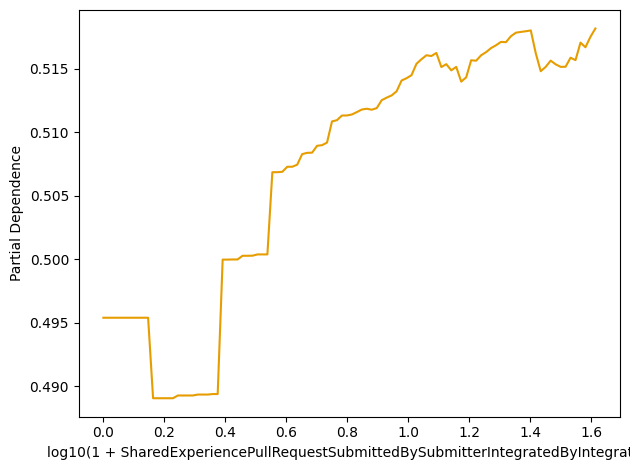

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(__rf, __df, __used_predictor_labels, model_name: str = "", average_only=True):
    if average_only:
        # Collective partial dependence plot.
        PartialDependenceDisplay.from_estimator(
            __rf, __df, __used_predictor_labels)

        fig = plt.gcf()
        axs = fig.axes

        lines = []
        for ax in axs:
            __lines = list([(line.get_xdata(), line.get_ydata())
                            for line in ax.lines])
            lines.extend(__lines)

        for (x, y), label in zip(lines, __used_predictor_labels):
            plt.clf()
            plt.plot(x, y, linestyle='-', color='#e69d00')
            plt.xlabel(label)
            plt.ylabel('Partial Dependence')
            plt.tight_layout()
            output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
            safe_save_fig(output_path)

    else:
        # TODO: create a plot where the average response is displayed
        # as a line, and the min/max as a grey area around it.
        pdd = PartialDependenceDisplay.from_estimator(
            __rf, __df, __used_predictor_labels, kind='individual')


create_partial_dependence_plots(weighted_rf,
                                test_predictors, used_predictor_labels,
                                model_name="weighted")

create_partial_dependence_plots(unweighted_rf,
                                test_predictors, used_predictor_labels,
                                model_name="unweighted")


## Logistic Regression

### Model Creation (Unweighted)

In [ ]:
from sklearn.linear_model import LogisticRegression


def create_unweighted_lr_model(__train_labels, __train_predictors,
                               __test_labels, __test_predictors,
                               __test_imbalance_weights):

    unweighted_lr = LogisticRegression()
    unweighted_lr.fit(__train_predictors, __train_labels)

    lr_predictions = unweighted_lr.predict(__test_predictors)
    absolute_error = abs(lr_predictions ^ __test_labels)
    print(f'{absolute_error=}')

    mean_accuracy = unweighted_lr.score(__test_predictors, __test_labels)
    print(f'{mean_accuracy=}')

    unweighted_f1 = f1_score(__test_labels, lr_predictions)
    print(f'{unweighted_f1=}')
    weighted_f1 = f1_score(__test_labels, lr_predictions,
                           sample_weight=__test_imbalance_weights)
    print(f'{weighted_f1=}')

    conf = confusion_matrix(__test_labels, lr_predictions)
    print(f'{conf=}')

    print(classification_report(__test_labels, lr_predictions))

    return unweighted_lr


unweighted_lr = create_unweighted_lr_model(train_labels, train_predictors,
                                           test_labels, test_predictors,
                                           test_imbalance_weights)


### Model Creation (Weighted)

In [ ]:
def create_weighted_lr_model(__test_labels, __test_predictors,
                             __test_imbalance_weights,
                             __train_labels, __train_predictors,
                             __train_imbalance_weights):

    weighted_lr = LogisticRegression()
    weighted_lr.fit(__train_predictors, __train_labels,
                    sample_weight=__train_imbalance_weights)

    lr_predictions = weighted_lr.predict(__test_predictors)

    mean_accuracy = weighted_lr.score(__test_predictors, __test_labels,
                                      sample_weight=__test_imbalance_weights)
    print(f'{mean_accuracy=}')

    absolute_error = abs(lr_predictions ^ __test_labels)
    print(f'{absolute_error=}')

    weighted_f1 = f1_score(__test_labels, lr_predictions,
                           sample_weight=__test_imbalance_weights)
    print(f'{weighted_f1=}')
    unweighted_f1 = f1_score(__test_labels, lr_predictions)
    print(f'{unweighted_f1=}')

    conf = confusion_matrix(__test_labels, lr_predictions)
    print(f'{conf=}')

    print(classification_report(__test_labels,
                                lr_predictions,
                                sample_weight=__test_imbalance_weights))

    return weighted_lr


weighted_lr = create_weighted_lr_model(test_labels, test_predictors, test_imbalance_weights,
                                       train_labels, train_predictors, train_imbalance_weights)


In [ ]:
print(all_predictors.columns)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

all_same = sum([abs(a - b) for a, b in zip(all_predictors['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate'], 
                            all_predictors['IntraProjectSubmitterPullRequestSuccessRate'])])
print(f'{all_same=}')
# print(all_predictors[fields])

endo = all_predictors['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate'].values
exo = all_predictors['IntraProjectSubmitterPullRequestSuccessRate'].values
lin_mod = sm.OLS(endo, exo)
res = lin_mod.fit()

print(res.summary())
# all_predictors = all_predictors.drop(
#     ["ControlIntraProjectPullRequestSuccessRateSubmitter"], axis=1)

# # create DataFrame to hold VIF values
# vif_df = pd.DataFrame()
# vif_df['variable'] = all_predictors.columns

# # calculate VIF for each predictor variable
# vif_df['VIF'] = [variance_inflation_factor(all_predictors.values, i)
#                  for i in range(all_predictors.shape[1])]

# print(vif_df)


### Calculate coefficients, p-values etc.

In [ ]:
import statsmodels.api as sm


def calculate_lr_stats(__predictors, __labels):
    value_mapper = {False: 0, True: 1}
    for feature in binary_fields:
        __predictors.loc[:, feature] = __predictors[feature].replace(value_mapper)

    replaced_labels = __labels.replace(value_mapper)

    sm_lr = sm.Logit(replaced_labels, __predictors)
    result = sm_lr.fit()
    # result = sm_lr.fit_regularized(maxiter=200)

    print(result.params)

    result.pred_table()

    print('summary 1:')
    print(result.summary())

    print('summary 2:')
    print(result.summary2())


# NOTE: this is done with ALL data; i.e., it doesn't respect the train/test stuff.
calculate_lr_stats(all_predictors, all_labels)


# Modelling (First-time Contributors Only)

## Dataset creation

In [20]:
ftc_df = df[df['SubmitterIsFirstTimeContributor']]
print(f'{len(ftc_df)=}')

# Split into train test
ftc_train, ftc_test = train_test_split(ftc_df, test_size=0.2)
print(f'{len(ftc_train)=}, {len(ftc_test)=}\n')

# Get predictors and labels.
ftc_train_predictors = ftc_train[used_predictor_labels]
ftc_train_labels = ftc_train[pr_merged_key]
ftc_test_predictors = ftc_test[used_predictor_labels]
ftc_test_labels = ftc_test[pr_merged_key]

ftc_all_predictors = ftc_df[used_predictor_labels]
ftc_all_labels = ftc_df[pr_merged_key]

# Calculates class imbalance.
class_counts = ftc_df[pr_merged_key].value_counts()
class_imbalance = max(class_counts) / min(class_counts)
majority_class = class_counts[np.argmax(class_counts)]
print(f'{class_counts=}')
print(f'{class_imbalance=}\n')

# Gets imbalance weights.
ftc_train_imbalance_weights = get_imbalance_weights(ftc_train_labels)
ftc_test_imbalance_weights = get_imbalance_weights(ftc_test_labels)


len(ftc_df)=536234
len(ftc_train)=428987, len(ftc_test)=107247

class_counts=PullRequestIsMerged
True     339039
False    197195
Name: count, dtype: int64
class_imbalance=1.7193082988919597



## Dataset Visualization

Creates histograms of the variables, and performs a chi-squared test to compare merged distribution with the non-first contributor data.

In [ ]:
create_predictor_histograms(ftc_df, subfolder_name="ftc")

In [42]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(
    df[first_time_contributor_key], df[pr_merged_key])
print(contingency)
results = (c, p, dof, exp) = chi2_contingency(contingency)
print(results)
print(f'{p=}')

PullRequestIsMerged               False    True 
SubmitterIsFirstTimeContributor                 
False                            225126  1068611
True                             197195   339039
Chi2ContingencyResult(statistic=80147.10285497761, pvalue=0.0, dof=1, expected_freq=array([[298568.83173395, 995168.16826605],
       [123752.16826605, 412481.83173395]]))
p=0.0


## Random Forest (weighted and unweighted)

In [ ]:
w_rf = create_weighted_rf_model(ftc_test_labels, ftc_test_predictors, ftc_test_imbalance_weights,
                                ftc_train_labels, ftc_train_predictors, ftc_train_imbalance_weights)

create_partial_dependence_plots(w_rf, test_predictors, used_predictor_labels, model_name="ftc_weighted")

# u_rf = create_unweighted_rf_model(ftc_test_labels, ftc_test_predictors,
#                                   ftc_train_labels, ftc_train_predictors,
#                                   ftc_test_imbalance_weights)

# create_partial_dependence_plots(u_rf, test_predictors, used_predictor_labels, model_name="ftc_unweighted")


## Logistic Regression (unweighted)

In [ ]:
create_unweighted_lr_model(ftc_test_labels, ftc_test_predictors,
                           ftc_train_labels, ftc_train_predictors,
                           ftc_test_imbalance_weights)

calculate_lr_stats(ftc_all_predictors, ftc_all_labels)
